In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Flatten, Dense, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

# Data Input and Model Creation

In [2]:
"""
Function takes in preprocessed data (classes balanced, duplicates removed, NOT normalized)
The standard scaler has to be exported so it is important to normalize the data here

Change the paths in trainFull and TestFull to desired preprocessedData

"""
def getPreprocessedData():
    
    #Concatenate positive and negative samples
    trainFull = pd.read_csv("PreprocessedData/trainFull.csv", index_col = 0)
    testFull = pd.read_csv("PreprocessedData/testFull.csv", index_col = 0)
    
    #Randomize samples
    trainFull = trainFull.sample(len(trainFull))
    testFull = testFull.sample(len(testFull))

    #Randomize samples
    trainFull = trainFull.sample(len(trainFull))
    testFull = testFull.sample(len(testFull))

    #Reduce features and extract labels
    trainX = trainFull.iloc[:,:-1]
    trainY = trainFull.iloc[:,-1]
    testX = testFull.iloc[:,:-1]
    testY = testFull.iloc[:,-1]

    #Reshape data to 3D for CNN
    trainX = trainX.to_numpy()[..., None]
    trainY = trainY.to_numpy()[..., None]
    testX = testX.to_numpy()[..., None]
    testY = testY.to_numpy()[..., None]

    return trainX, trainY, testX, testY


In [3]:
"""
This method contains the architecture for the CNN used.
It uses tensorflow sequential as the basis to crease the model.

@param numConvFilters: number of convolutional filters in the 2nd hidden layer. We recommend >32 to upscale.
@param dropout: fraction of nodes dropped out of the Max Pooling layer.
@param numDenseNodes: number of dense nodes in the feed forward layer.

Recommended:
numConvFilters = 242
dropout = .215
numDenseNodes = 190

"""
def newModel(numConvFilters = 242, dropout = .215, numDenseNodes = 190):
    #Create new sequential model
    model = Sequential()

    #Add 1D Convolutional layers
    model.add(BatchNormalization())
    model.add((Conv1D(filters=32, kernel_size=3, activation='relu')))
    model.add((Conv1D(filters=numConvFilters, kernel_size=3, activation='relu')))
    #Add Max Pooling layer
    model.add((MaxPooling1D(pool_size=2)))
    #Apply dropout
    model.add(Dropout(dropout))
    #Flatten model
    model.add(Flatten())
    #Add fully connected dense layer
    model.add(Dense(numDenseNodes, activation='sigmoid'))
    #Add output node
    model.add(Dense(1, activation='sigmoid'))
    
    #Define optimizer
    adam = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #Compile model
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'),                                                                                         tf.keras.metrics.PrecisionAtRecall(0.8)])
    return model

In [4]:
trainX, trainY, testX, testY = getPreprocessedData()
model = newModel()
model.fit(trainX, trainY, epochs = 100, batch_size=20, verbose = 1)

2022-04-26 10:36:02.137617: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-26 10:36:02.971068: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
758/758 [==============================] - 23s 27ms/step - loss: 0.6809 - auc: 0.5780 - precision_at_recall: 0.5346
Epoch 2/100
758/758 [==============================] - 17s 22ms/step - loss: 0.6571 - auc: 0.6318 - precision_at_recall: 0.5684
Epoch 3/100
758/758 [==============================] - 16s 21ms/step - loss: 0.6458 - auc: 0.6524 - precision_at_recall: 0.5809
Epoch 4/100
758/758 [==============================] - 16s 21ms/step - loss: 0.6405 - auc: 0.6598 - precision_at_recall: 0.5881
Epoch 5/100
758/758 [==============================] - 16s 21ms/step - loss: 0.6346 - auc: 0.6682 - precision_at_recall: 0.5938
Epoch 6/100
758/758 [==============================] - 16s 21ms/step - loss: 0.6333 - auc: 0.6679 - precision_at_recall: 0.5960
Epoch 7/100
758/758 [==============================] - 16s 21ms/step - loss: 0.6292 - auc: 0.6755 - precision_at_recall: 0.6010
Epoch 8/100
758/758 [==============================] - 16s 21ms/step - loss: 0.6229 - auc: 0.6878 - prec

758/758 [==============================] - 16s 20ms/step - loss: 0.4093 - auc: 0.8925 - precision_at_recall: 0.7967
Epoch 65/100
758/758 [==============================] - 15s 20ms/step - loss: 0.4070 - auc: 0.8945 - precision_at_recall: 0.8003
Epoch 66/100
758/758 [==============================] - 15s 20ms/step - loss: 0.4023 - auc: 0.8965 - precision_at_recall: 0.8007
Epoch 67/100
758/758 [==============================] - 15s 20ms/step - loss: 0.4003 - auc: 0.8974 - precision_at_recall: 0.8035
Epoch 68/100
758/758 [==============================] - 19s 26ms/step - loss: 0.3977 - auc: 0.8997 - precision_at_recall: 0.8065
Epoch 69/100
758/758 [==============================] - 20s 26ms/step - loss: 0.3929 - auc: 0.9021 - precision_at_recall: 0.8098
Epoch 70/100
758/758 [==============================] - 17s 22ms/step - loss: 0.3922 - auc: 0.9021 - precision_at_recall: 0.8126
Epoch 71/100
758/758 [==============================] - 16s 21ms/step - loss: 0.3895 - auc: 0.9043 - precision

# Validation and Analysis 

In [5]:
#create confusion Matrix
def confusionMatrix(model, testX, testY):
    pred = model.predict(testX)
    predy = []
    for i in range(0,len(pred)):
        if pred[i] >= .5:
            predy.append(1)
        else:
            predy.append(0)
        
    print(confusion_matrix(testY,predy))
    
#Calculates our model metrics
def modelMetrics(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    rec80 = np.max(recall[precision >= .8])
    print("Recall at 80% Precision: " +str(rec80))
    aucPR = auc(recall, precision)
    print("PR-AUC: " + str(aucPR))
    
    return rec80, aucPR, 

#plots a PR curve
def PRplot(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    plt.plot(recall, precision)
    plt.title("PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

Recall at 80% Precision: 0.8717678100263853
PR-AUC: 0.9108506722715662
[[1540  355]
 [ 302 1593]]


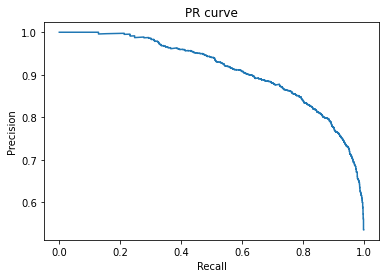

In [6]:
modelMetrics(testX, testY, model)
confusionMatrix(model, testX, testY)
PRplot(testX, testY, model)